importation des bibliothèque nécessaire

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Pour la modélisation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Modèles
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier  # Assurez-vous d'avoir installé catboost (pip install catboost)
from sklearn.svm import SVC

# Pipeline et normalisation pour SVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

PARTIE 1 : CHARGEMENT & IMPUTATION DES DONNEES

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv"
data = pd.read_csv(url, header=0)
data = data.replace('?', pd.NA) # Replace '?' with NA
data = data.apply(pd.to_numeric, errors='coerce') # Convert to numeric values
print(data.head())

   Age  Number of sexual partners  First sexual intercourse  \
0   18                        4.0                      15.0   
1   15                        1.0                      14.0   
2   34                        1.0                       NaN   
3   52                        5.0                      16.0   
4   46                        3.0                      21.0   

   Num of pregnancies  Smokes  Smokes (years)  Smokes (packs/year)  \
0                 1.0     0.0             0.0                  0.0   
1                 1.0     0.0             0.0                  0.0   
2                 1.0     0.0             0.0                  0.0   
3                 4.0     1.0            37.0                 37.0   
4                 4.0     0.0             0.0                  0.0   

   Hormonal Contraceptives  Hormonal Contraceptives (years)  IUD  ...  \
0                      0.0                              0.0  0.0  ...   
1                      0.0                            

Suppression des colonnes avec plus de 50% de valeurs manquantes

In [7]:
threshold = len(data) * 0.5  
data_cleaned = data.dropna(thresh=threshold, axis=1)
data_cleaned = data_cleaned.copy()  # Pour éviter les avertissements

# Conversion de "Biopsy" en entier
data_cleaned.loc[:, "Biopsy"] = data_cleaned["Biopsy"].astype(int)
# Liste des colonnes avant et après traitement
columns_before = data.columns
columns_after = data_cleaned.columns

# Colonnes supprimées
removed_columns = list(set(columns_before) - set(columns_after))
print("Colonnes supprimées : ", removed_columns)


Colonnes supprimées :  ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis']


Conversion explicite en float pour les colonnes suspectées

In [9]:
# Liste des colonnes supposées numériques (pour conversion explicite)
numeric_cols_suspected = [
    "Age",
    "Number of sexual partners",
    "First sexual intercourse",
    "Num of pregnancies",
    "Smokes",
    "Smokes (years)",
    "Smokes (packs/year)",
    "Hormonal Contraceptives (years)",
    "IUD (years)",
    "STDs",
    "STDs (number)",
    "STDs: Number of diagnosis",
    "STDs: Time since first diagnosis",
    "STDs: Time since last diagnosis"
]
# Conversion explicite en float pour les colonnes suspectées
for col in numeric_cols_suspected:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
print(data[numeric_cols_suspected].dtypes)

Age                                   int64
Number of sexual partners           float64
First sexual intercourse            float64
Num of pregnancies                  float64
Smokes                              float64
Smokes (years)                      float64
Smokes (packs/year)                 float64
Hormonal Contraceptives (years)     float64
IUD (years)                         float64
STDs                                float64
STDs (number)                       float64
STDs: Number of diagnosis             int64
STDs: Time since first diagnosis    float64
STDs: Time since last diagnosis     float64
dtype: object


Transformation log et winsorisation pour réduire l'asymétrie et limiter les outliers

In [10]:
columns_to_treat = ['Age', 'First sexual intercourse']
for col in columns_to_treat:
    skew_val = data_cleaned[col].skew()
    data_cleaned[col + '_log'] = np.log1p(data_cleaned[col])
    winsorized_values = np.array(winsorize(data_cleaned[col + '_log'], limits=(0.05, 0.05)))
    data_cleaned[col + '_log_winsorized'] = winsorized_values
    print(f"Colonne '{col}' (skewness = {skew_val:.2f}): transformation log et winsorisation appliquées.")

Colonne 'Age' (skewness = 1.39): transformation log et winsorisation appliquées.
Colonne 'First sexual intercourse' (skewness = 1.56): transformation log et winsorisation appliquées.


Imputation des valeurs manquantes sur l'original par la valeur médiane (hors cible)

In [12]:
for col in data.columns:
    if col == "Biopsy":
        continue
    if data[col].dtype in [np.float64, np.int64]:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        mode_val = data[col].mode(dropna=True)
        if not mode_val.empty:
            data[col].fillna(mode_val[0], inplace=True)
        else:
            data[col].fillna("Inconnu", inplace=True)
# Vérifier les valeurs manquantes après imputation
missing_values = data.isnull().sum()
print("Valeurs manquantes après imputation :")
print(missing_values)


Valeurs manquantes après imputation :
Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
ST

PARTIE 2 : PRÉPARATION DES DONNÉES POUR LA MODÉLISATION  

Cette étape consiste à préparer les données pour la modélisation. Les données doivent être nettoyées, traitées et organisées de manière à ce qu’elles soient équilibreés et représentatives de la population cible.
Pour cela on a utiliser la méthode smote qui est une méthode de suramplification de données minoritaires. Elle consiste à créer de nouvelles instances de données minoritaires en fonction des données existantes.

In [13]:
# Séparation des features (X) et de la cible (y) à partir de data_cleaned
X = data_cleaned.drop(columns=['Biopsy'])
y = data_cleaned['Biopsy']

# Division en ensembles d'entraînement et de test (sans stratification ici pour SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation des valeurs manquantes dans X_train avec la médiane (pour SMOTE)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)

# Application de SMOTE sur l'ensemble d'entraînement imputé
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

print("\nRépartition des classes après SMOTE:")
print(pd.Series(y_train_res).value_counts())


Répartition des classes après SMOTE:
Biopsy
0    642
1    642
Name: count, dtype: int64


PARTIE 3 : RÉDUCTION DE LA MULTICOLLINÉARITÉ

Colonnes supprimées : ['STDs (number)', 'STDs:condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs: Number of diagnosis', 'Dx:HPV', 'Age_log_winsorized', 'First sexual intercourse_log_winsorized']
Dimensions du DataFrame réduit : (858, 29)


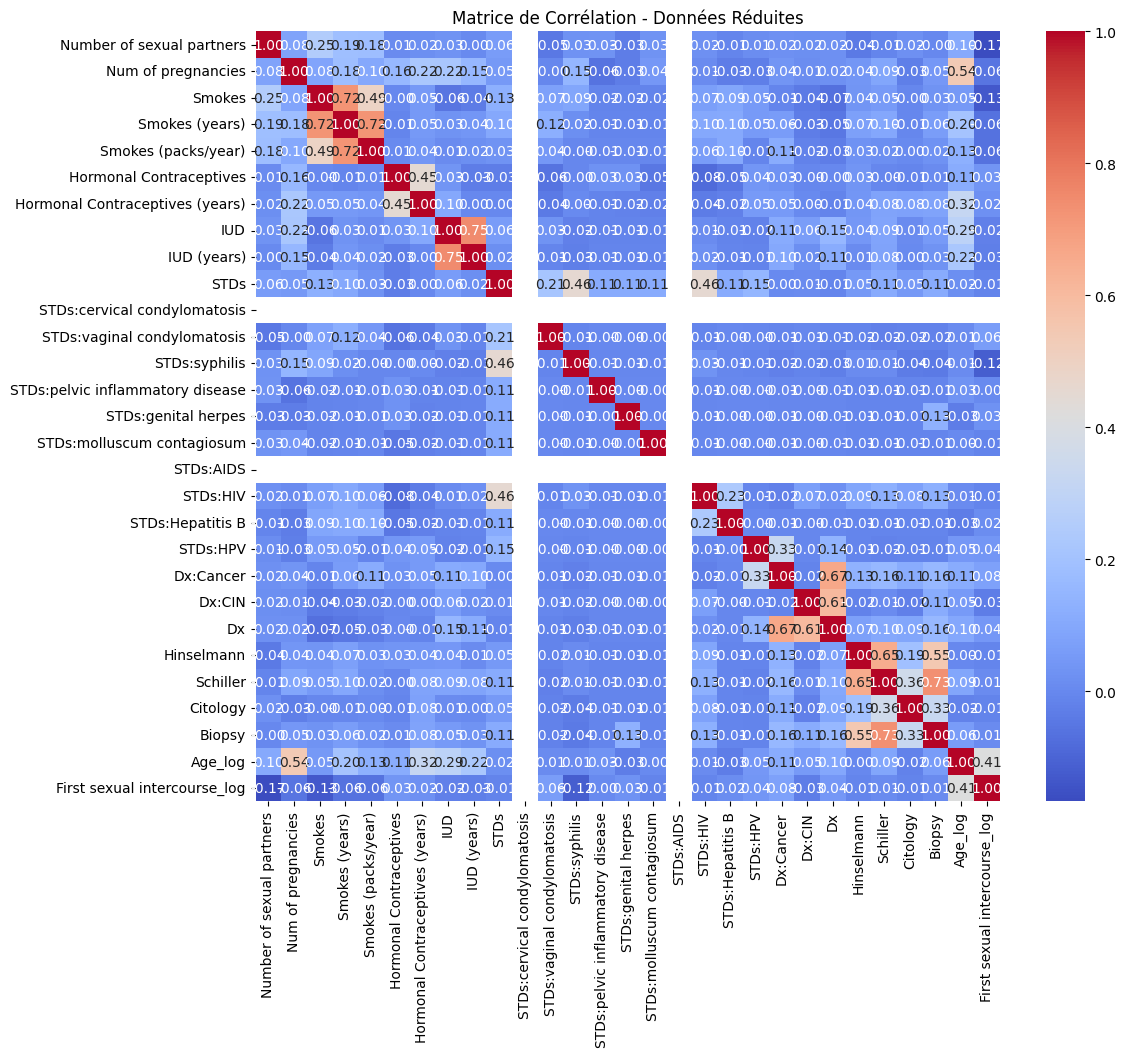

In [14]:
# On retire les colonnes originales utilisées pour les transformations
colonnes_a_exclure = ['Age', 'First sexual intercourse']
data_final = data_cleaned.drop(columns=colonnes_a_exclure)

# Calcul de la matrice de corrélation en valeurs absolues
corr_matrix = data_final.corr().abs()

# Extraction de la partie supérieure triangulaire pour éviter les doublons
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identification des colonnes à supprimer si corrélation > 0.8 avec au moins une autre variable
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]

# Suppression des colonnes identifiées
data_final_reduced = data_final.drop(columns=to_drop)

print("Colonnes supprimées :", to_drop)
print("Dimensions du DataFrame réduit :", data_final_reduced.shape)

# Affichage de la matrice de corrélation du DataFrame réduit via une heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data_final_reduced.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de Corrélation - Données Réduites")
plt.show()